# Compiling the building footprints of Electrical substations (onderstations)

The objective of this notebook is to compile a data set consisting of electrical substation footprints as a supporting solution for lvc reconstructor and path-finder problem.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pyproj
import osmnx  as ox
import tqdm
from shapely.ops import unary_union

/var/folders/bh/hhr2wkwn2ldcpz5w4tgn7sb80000gn/T/ipykernel_69917/2294959928.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
CRS = 4326

stations = gpd.read_parquet('../../data/liander/onderstations.pyarrow')
stations = stations.to_crs(pyproj.CRS.from_epsg(CRS))
stations.head()

,id,geometry
0,680162505,POINT (4.96553 52.33297)
1,724198747,POINT (5.72333 52.84813)
2,728801999,POINT (5.76228 52.68395)
3,760866446,POINT (6.37847 51.90356)
4,764986551,POINT (6.21951 52.14935)


In [3]:
verzorgingsgebied = gpd.read_parquet('../../data/atom/verzorgingsgebied.parquet')
verzorgingsgebied = verzorgingsgebied.to_crs(CRS)
verzorgingsgebied.head()

,id,station,netbeheerder,status,totaleCapaciteitInvoedingMva,totaleCapaciteitAfnameMva,beschikbareCapaciteitInvoedingHuidigMva,beschikbareCapaciteitAfnameHuidigMva,verwachtJaarVanOverbelastingInvoeding,verwachtJaarVanOverbelastingAfname,...,peildatum,beschikbareCapaciteitAfname3JaarMvaVisualisatie,beschikbareCapaciteitAfname5JaarMvaVisualisatie,beschikbareCapaciteitAfname10JaarMvaVisualisatie,beschikbareCapaciteitAfnameHuidigMvaVisualisatie,beschikbareCapaciteitInvoeding3JaarMvaVisualisatie,beschikbareCapaciteitInvoeding5JaarMvaVisualisatie,beschikbareCapaciteitInvoeding10JaarMvaVisualisatie,beschikbareCapaciteitInvoedingHuidigMvaVisualisatie,geometry
0,indicatief_verzorgingsgebied.3f7b1732-778d-4b1...,Wittevrouweveld,Enexis,Bestaand,35,35,34.0,10.0,2028,2035,...,2022-12-14,10,10,10,10,34,34,34,34,"MULTIPOLYGON (((5.66455 50.83226, 5.70274 50.8..."
1,indicatief_verzorgingsgebied.0a727e27-ba60-487...,Boschpoort,Enexis,Bestaand,45,45,6.0,23.0,2023,2035,...,2022-12-14,23,23,23,23,6,6,6,6,"MULTIPOLYGON (((5.64897 50.82704, 5.64918 50.8..."
2,indicatief_verzorgingsgebied.ed973a51-edcc-40e...,Heer,Enexis,Bestaand,40,40,38.0,0.0,2028,2023,...,2022-12-14,0,0,0,0,38,38,38,38,"MULTIPOLYGON (((5.83113 50.75886, 5.83102 50.7..."
3,indicatief_verzorgingsgebied.9e164099-7d30-41a...,Schoonbron,Enexis,Bestaand,45,47,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((5.91508 50.75040, 5.91508 50.7..."
4,indicatief_verzorgingsgebied.adc9060f-a6b2-4dd...,Terwinselen,Enexis,Bestaand,110,116,0.0,0.0,2023,2023,...,2022-12-14,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((6.05465 50.92368, 6.05450 50.9..."


In [4]:
ms = gpd.read_parquet('../../data/liander/middenspanningskabels.pyarrow')
ms = ms.to_crs(pyproj.CRS.from_epsg(CRS))
ms = pd.concat([ms, ms.bounds], axis=1)
ms.head()

,id,geometry,minx,miny,maxx,maxy
0,10255800,"LINESTRING (5.71308 51.93644, 5.71308 51.93644...",5.713075,51.936441,5.716208,51.936871
1,10255816,"LINESTRING (5.55664 51.92032, 5.55665 51.92031...",5.555937,51.919655,5.556735,51.920319
2,10255842,"LINESTRING (5.51975 51.94033, 5.51987 51.94030...",5.519753,51.939955,5.521645,51.940371
3,10255858,"LINESTRING (5.52608 51.96371, 5.52661 51.96372...",5.526082,51.963712,5.526847,51.964128
4,10255872,"LINESTRING (5.75006 51.90587, 5.75009 51.90582...",5.750056,51.901774,5.752254,51.905867


## Determine the building footprint of the substations

Obtain pre-building footprints given geocode and distance

In [5]:
%%time
%%capture

import warnings
warnings.filterwarnings('ignore')

foot_prints = []

for sample in stations.values:
    coords = sample[1].coords
    poi = (coords[0][1], coords[0][0])
    foot_print = ox.geometries_from_point(poi, {"building": True}, dist=160)
    foot_prints.append(foot_print)

CPU times: user 2.43 s, sys: 161 ms, total: 2.59 s
Wall time: 2.81 s


In [51]:
# building_footprint_store = []
#
# def data_compiler(poi_idx: int, buildings_of_interest_idx: list, footprints, store: list):
#     found_buildings = foot_prints[poi_idx]
#     buildings_one = found_buildings[found_buildings['ref:bag'].isin(buildings_of_interest_idx)]
#
#     to_union = buildings_one.reset_index()[['ref:bag', 'geometry']]
#     unified = unary_union(to_union.geometry)
#     station_idx = unified.intersects(verzorgingsgebied.geometry)
#
#     if sum(station_idx) == 1:
#         found_station = verzorgingsgebied[station_idx].iloc[0, :]
#         station_id = found_station.id
#         name = found_station.station
#         network_operator = found_station.netbeheerder
#         ref_bag = ','.join(to_union['ref:bag'].values)
#         footprint = unified
#         store.append([station_id, name, network_operator, ref_bag, footprint])

In [115]:
# poi_idx = 7
# foot_prints[poi_idx]

nodes  \
element_type osmid                                                          
way          267542984  [2729836766, 2729836737, 2729836721, 272983672...   
             267543363  [2729836767, 2729836768, 2729836764, 272983677...   
             267545239  [2729836757, 2729836769, 2729836763, 272983675...   
             267546291  [2729836787, 2729836785, 2729836783, 272983678...   
             267546863  [2729836774, 2729836776, 2729836752, 272983673...   
             267547171  [2729836662, 2729836686, 2729836735, 272983674...   
             267569202  [2729995324, 2729994822, 2729994769, 272999479...   
             267570081  [2729994828, 2729995022, 2729995380, 272999499...   
             267570560  [2729995415, 2729995335, 2729995048, 272999538...   
             267571064  [2729990388, 2729990752, 2729987939, 272998730...   
             267572676  [2729995366, 2729995322, 2729995014, 272999503...   
             267573367  [2729993093, 2729993883, 2729993180, 272999388...   
             267726595  [2731417097, 2731417052, 2731417103, 273141713...   
             267727205  [2731416090, 2731416387, 2731416127, 273141581...   
             267727808  [2731417072, 2731417045, 2731417057, 273141708...   
             499512617  [4907818247, 4907818246, 4907818245, 490781824...   
             499512619  [4907818251, 4907818250, 4907818249, 490781824...   

                              building          ref:bag source source:date  \
element_type osmid                                                           
way          267542984           house  394100001002018    BAG  2014-02-11   
             267543363           house  394100001005552    BAG  2014-02-11   
             267545239             yes  394100000228577    BAG  2014-02-11   
             267546291      apartments  394100000238658    BAG  2014-02-11   
             267546863           house  394100001005551    BAG  2014-02-11   
             267547171      apartments  394100001009994    BAG  2014-02-11   
             267569202             yes  394100000228582    BAG  2014-02-11   
             267570081      apartments  394100000238383    BAG  2014-02-11   
             267570560             yes  394100001022299    BAG  2014-02-11   
             267571064             yes  394100001021659    BAG  2014-02-11   
             267572676           house  394100001003330    BAG  2014-02-11   
             267573367             yes  394100000229234    BAG  2014-02-11   
             267726595      industrial  394100000228580    BAG  2014-02-11   
             267727205      commercial  394100001022001    BAG  2014-02-11   
             267727808             yes  394100000240751    BAG  2014-02-11   
             499512617  static_caravan  394030000347858    BAG  2017-06-10   
             499512619      industrial  394100001024876    BAG  2017-06-10   

                       start_date  \
element_type osmid                  
way          267542984       2005   
             267543363       2005   
             267545239       2005   
             267546291       2005   
             267546863       2005   
             267547171       2005   
             267569202       2005   
             267570081       2003   
             267570560       2011   
             267571064       2010   
             267572676       2004   
             267573367       2009   
             267726595       1993   
             267727205       2001   
             267727808       1993   
             499512617        NaN   
             499512619       2016   

                                                                 geometry  \
element_type osmid                                                          
way          267542984  POLYGON ((4.64111 52.30974, 4.64124 52.30967, ...   
             267543363  POLYGON ((4.64111 52.30974, 4.64111 52.30975, ...   
             267545239  POLYGON ((4.64150 52.30971, 4.64156 52.30975, ...   
             267546291  POLYGON 

In [116]:
# to_save = foot_prints[poi_idx].explore(popup='ref:bag')
# to_save.save('test.html')

In [117]:
# buildings_of_interest = ['394100000228580', '394100001024876']

In [ ]:
# data_compiler(poi_idx, buildings_of_interest, foot_prints, building_footprint_store)

In [119]:
# compiled_footprints = gpd.GeoDataFrame(building_footprint_store,
#                  columns=['station_id', 'name', 'network_operator', 'ref:bag', 'geometry'])
#
# compiled_footprints

,station_id,name,network_operator,ref:bag,geometry
0,indicatief_verzorgingsgebied.b6b93dcc-10a1-4f2...,OS VENSERWEG,Liander,"384100000001678,384100000001727","MULTIPOLYGON (((4.96526 52.33329, 4.96533 52.3..."
1,indicatief_verzorgingsgebied.9df8f955-e29e-406...,OS LEMMER,Liander,82100000153097,"POLYGON ((5.72436 52.84831, 5.72443 52.84825, ..."
2,indicatief_verzorgingsgebied.6cebe376-b1af-4f4...,OS EMMELOORD,Liander,"0171100000027236,171100000035791","MULTIPOLYGON (((5.76116 52.68342, 5.76122 52.6..."
3,indicatief_verzorgingsgebied.fe5a538f-6d0b-454...,OS ULFT,Liander,"1509100000204755,1509100000257802","MULTIPOLYGON (((6.37868 51.90361, 6.37847 51.9..."
4,indicatief_verzorgingsgebied.24a95390-a145-4c3...,OS ZUTPHEN,Liander,"301100000001151,301100000000211,03011000000338...","MULTIPOLYGON (((6.22016 52.14925, 6.22019 52.1..."
5,indicatief_verzorgingsgebied.24a95390-a145-4c3...,OS ZUTPHEN,Liander,"0301100000031940,0301100000031938","POLYGON ((6.21980 52.14919, 6.21970 52.14920, ..."
6,indicatief_verzorgingsgebied.e6c4342e-48eb-4ad...,OS HARSELAAR,Liander,0203100000418254,"POLYGON ((5.62058 52.16401, 5.62066 52.16406, ..."
7,indicatief_verzorgingsgebied.7fc89b04-db36-4c6...,OS HAARLEMMERMEER,Liander,"394100000228580,394100001024876","MULTIPOLYGON (((4.64239 52.31129, 4.64265 52.3..."


In [120]:
# compiled_footprints.to_feather('compiled_footprints.feather', index=False)

## Design Algorithm for determining the footprints

Since the algorithm does obtain a clean determination of footprints to a certain extent, a small manual process needs to be applied.

In [ ]:
# building_footprint_store = []
#
# def data_compiler(poi_idx: int, buildings_of_interest_idx: list, footprints, store: list):
#     found_buildings = foot_prints[poi_idx]
#     buildings_one = found_buildings[found_buildings['ref:bag'].isin(buildings_of_interest_idx)]
#
#     to_union = buildings_one.reset_index()[['ref:bag', 'geometry']]
#     unified = unary_union(to_union.geometry)
#     station_idx = unified.intersects(verzorgingsgebied.geometry)
#
#     if sum(station_idx) == 1:
#         found_station = verzorgingsgebied[station_idx].iloc[0, :]
#         station_id = found_station.id
#         name = found_station.station
#         network_operator = found_station.netbeheerder
#         ref_bag = ','.join(to_union['ref:bag'].values)
#         footprint = unified
#         store.append([station_id, name, network_operator, ref_bag, footprint])

In [63]:
%%time

import warnings
warnings.filterwarnings('ignore')

tuned_footprints = {}

for idx in tqdm.tqdm_notebook(range(len(foot_prints))):
    foot_print = foot_prints[idx]
    area_of_interest = unary_union(foot_print.geometry)
    minx, miny, maxx, maxy = area_of_interest.bounds

    # faster computation utilizing union + min, max strategy
    aoi_lines = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)]
    osmids = foot_print.reset_index()['osmid']

    tmp_foot_print_wrapper = dict()
    tmp_foot_print_wrapper['osmids'] = []
    tmp_foot_print_wrapper['geometries'] = []
    tmp_foot_print_wrapper['union'] = None

    for building_idx in range(len(foot_print)):
        building = foot_print.iloc[building_idx]
        d = building.geometry.distance(aoi_lines.geometry)

        # cheating with np.array to solve array float issue with <class 'pandas.core.series.Series'> + <class 'geopandas.geoseries.GeoSeries'>
        d_idx = d[np.array(d) <= .000003].index
        if len(d_idx) > 0:
            tmp_foot_print_wrapper['geometries'].append(building.geometry)
            tmp_foot_print_wrapper['osmids'].append(str(osmids.iloc[building_idx]))

    if len(tmp_foot_print_wrapper['geometries']) > 0:
        tmp_foot_print_wrapper['union'] = unary_union(tmp_foot_print_wrapper['geometries'])
        tuned_footprints[idx] = tmp_foot_print_wrapper
    else:
        print(f'No match for footprint index {idx}')

  0%|          | 0/126 [00:00<?, ?it/s]

No match for footprint index 9
No match for footprint index 32
No match for footprint index 100
No match for footprint index 103
No match for footprint index 114
CPU times: user 6.91 s, sys: 46.5 ms, total: 6.96 s
Wall time: 6.96 s


In [84]:
compiled_footprints = gpd.GeoDataFrame({
    'osmids': [y for x in tuned_footprints.values() for y in x['osmids']],
    'geometry': [y for x in tuned_footprints.values() for y in x['geometries']]
})

compiled_footprints.head()

,osmids,geometry
0,278868707,"POLYGON ((4.96655 52.33325, 4.96657 52.33328, ..."
1,278868713,"POLYGON ((4.96884 52.33150, 4.96886 52.33154, ..."
2,278868760,"POLYGON ((4.96572 52.33319, 4.96526 52.33329, ..."
3,278868837,"POLYGON ((4.96337 52.33173, 4.96333 52.33174, ..."
4,278868860,"POLYGON ((4.96650 52.33439, 4.96634 52.33448, ..."


For extracting Polygons from Multipolygons the following method can be applied ->

    list(tuned_footprints[some_index]['union'].geoms)
    # or
    list(compiled_footprints.iloc[0, -1].geoms)
    # of
    list(compiled_footprints.loc[0, 'geometry'].geoms)

this is required for the manual determination process for fine-tuning the footprints for each substation.

In [86]:
compiled_footprints.to_file('manual_selection.geojson', driver='GeoJSON')

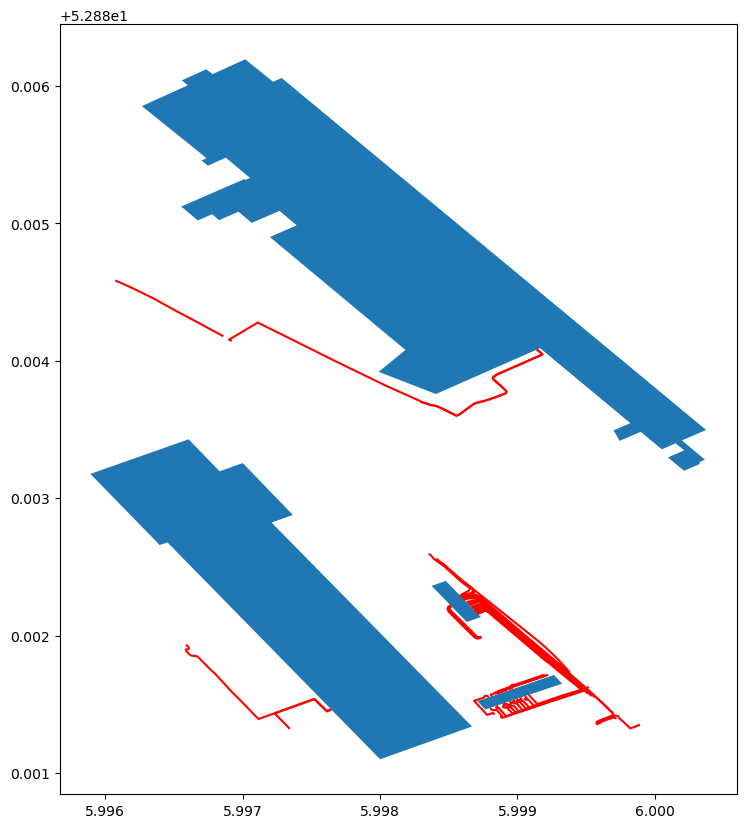

In [78]:
import matplotlib.pyplot as plt

poi_idx = 110
sample = compiled_footprints.iloc[poi_idx].geometry
minx, miny, maxx, maxy = sample.bounds

size = 10
fig, ax = plt.subplots(figsize=(size, size))

ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)].plot(ax=ax, color='red')
gpd.GeoDataFrame({
    'geometry': [sample]
}).plot(ax=ax);

In [157]:
lines_save = ms[(ms.minx >= minx) & (ms.miny >= miny) & (ms.maxx <= maxx) & (ms.maxy <= maxy)].explore(color='red')
lines_save.save('lines_save.html')